# Korteweg - de Vries

$$ u_{t} + \frac{\beta c}{4 E} (u^2)_{\xi} + \frac{\nu^2 R^2 c}{4} u_{\xi\xi\xi} = 0 $$

In [14]:
import numpy as np
import scipy as sp
import scipy.integrate
import matplotlib.pyplot as plt
from matplotlib import animation
import matplotlib
from IPython.display import HTML, clear_output, display
from ipywidgets import IntSlider, Output
plt.rcParams['animation.html'] = 'html5'
from log_progress import log_progress

Domain and initial condition function:

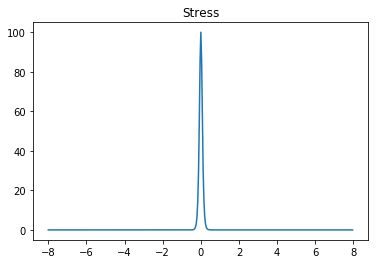

In [32]:
# m to mm
coord_scale = 1
# s to microsec
time_scale = 1

# domain
t0, tf = 0, 0.1*time_scale
dt = 1e-4
T = np.linspace(t0, tf, int((tf - t0)/dt + 1))
pN = 400
xl, xr = -8*coord_scale, 8*coord_scale
L = xr - xl
X = np.linspace(xl, xr, pN, endpoint=False)

# high frequency range for de-aliasing
hfreq1 = int(np.round(pN/3)) - 1
hfreq2 = int(np.round(2*pN/3)) + 1
da = np.ones_like(X)
da[hfreq1:hfreq2] = 0

# elastic moduli, radius, linear wave velocity
c = 1*coord_scale/time_scale
v_water = c
v = c - v_water
P = 100

def stress_tan(x, t):
    V = 0
    D = 0.1*coord_scale
    arg = ((x - V*t) - (xr + xl)/2)/D
    return P*np.cosh(arg)**(-2)
    
# nonlinear and dispersion coefficients
beta = -30
d = 1
g = 1

plt.title("Stress")
plt.plot(X, stress_tan(X, 0), )
plt.show()

Derivative function

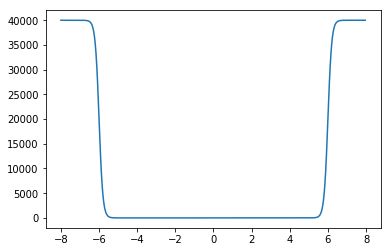

In [33]:
# normalize frequencies
xi = np.fft.fftfreq(len(X))*(len(X))*2*np.pi /(X[-1] - X[0])

# sponge
def sponge_coef_func(x):
    amplt = 20000
    kappa = 5
    lfrac = 3.0/4.0
    return amplt*( 1 + np.tanh(kappa*(x - lfrac*L/2)) 
                  +1 - np.tanh(kappa*(x + lfrac*L/2)))

sp_coef = sponge_coef_func(X)
plt.plot(X, sp_coef)
plt.show()

def der(t, u):
    u_orig = np.fft.ifft(u)
    u_sp = np.fft.fft(u_orig * sp_coef)
    u2 = np.fft.fft(u_orig**2)
    s = np.fft.fft(stress_tan(X, t))
    du = 1j*xi*(-v*u - beta*u2 + d*xi**2*u) - g*s - u_sp
    return du

Solve and plot

In [34]:
# de-aliased initial condition
sol = X*0
uk = np.fft.fft(sol)*da
# containers for solution and time
U = [sol,]
T_saved = [t0,]

In [42]:
out = Output()
display(out)

save_rate = 10
for i in log_progress(range(1, len(T)), every=save_rate):
    sln = sp.integrate.solve_ivp(der, (0, dt), uk, method='RK45')
    # extract solution
    u = sln.y[:, -1]
    # dealiasing
    u *= da
    # save solution at each n-th time-point
    if not i%save_rate:
        U.append(np.fft.ifft(u).real)
        T_saved.append(T[i])
        # plot solution
        out.clear_output(wait=True)
        with out:
            plt.plot(X, -U[-1])
            plt.show()
            print("time:     %.2f s" % T_saved[-1])
            dist = v_water*T_saved[-1]
            print("distance: %.2f m" % dist)
    # define next initial condition for integrator
    uk = u

Output()

VBox(children=(HTML(value=''), IntProgress(value=0, max=1000)))

In [40]:
T = T + T[-1]

In [41]:
T

array([0.1   , 0.1001, 0.1002, ..., 0.1998, 0.1999, 0.2   ])

In [55]:
direct = "KdV_forced_resonance/"
np.save(direct + "U.npy", U)
np.save(direct + "T.npy", T_saved)
np.save(direct + "X.npy", X)

In [45]:
fig, axes = plt.subplots(figsize=(8, 4))
plt.title('Soluton animation')
plt.xlim(X[0], X[-1]) 
plt.ylim(-0.5, 3)
plt.grid()
plt.xlabel("x, mm")
plt.ylabel("deform")
line1, = axes.plot([], [], lw=2)
line2, = axes.plot([], [], lw=2)
time_template = 'time = %.2f'
time_text = axes.text(0.85, 0.9, '', transform=axes.transAxes)
plt.minorticks_on()
plt.close()

def plot_frame(i):
    axes.set_xlim(X[0] + c*T_saved[i]*0, X[-1]+ c*T_saved[i]*0)
    line1.set_data(X + c*T_saved[i]*0, -U[i])
    time_text.set_text(time_template % T_saved[i])
    fig.canvas.draw()
    return fig

matplotlib.animation.FuncAnimation(fig, plot_frame, frames=len(U), interval=100, repeat=False)

In [51]:
T_saved = T_saved[:171]

In [53]:
np.shape(U[:171])

(171, 400)

In [54]:
U = U[:171]